# Classification
Using emoji to derive a twit sentiment is obvious; this exercise explores the opposite: [given plain text infer emoji](https://arxiv.org/abs/1702.07285). Taking in account that the word space and emotion attached might be almost orthogonal (emoticons are used to add information, rather then simply reflect the text), we reformulate the problem as `which`: lexical or non-lexical semantics have more weight in this relation.

In [1]:
STRUCTURE_OVER_CONTENT = True # non-lexical semantics

In [2]:
import os
import re
import numpy as np
import pandas as pd
from nltk.stem import SnowballStemmer, PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

Data was gathered by streaming twitter for an hour with empty query string on several days:

In [3]:
!cat gather.py

import os
import re
import sys
import time
import json
import client
from datetime import date


if  __name__ =='__main__':

    lang = 'en'
    if len(sys.argv) > 1:
        lang = sys.argv[1]

    lim = 1000000
    if len(sys.argv) > 2:
        lim = int(sys.argv[2])
    
    score = {}
    with open('emo-list.txt','r') as source:
        score = { chr(int(c)):{ 'total':0, 'positive':0, 'negative':0 }
                      for c in source.read().strip().split() }

    with open('data/{}/{}.csv'.format(lang, date.today().isoformat()), 'w') as output:
        output.write('text,emo\n')

        def extract(data):
            try:
                obj = json.loads(data)
                if obj['lang'] == lang: # remove links and non-word characters
                    words = re.sub("'", '', re.sub('(@\S+)|(https?\://\S+)|([\W\d_]+)', ' ',
                                                   obj['text'].lower())).split()
                    if len(words) > 0:
                        emo = {

In [4]:
data = None

for (dirpath, dirnames, filenames) in os.walk('data/en'):
    for f in filenames:
        if data is None:
            data = pd.read_csv('data/en/{}'.format(f))
        else:
            data = data.append(pd.read_csv('data/en/{}'.format(f)), ignore_index = True)
    break

print(data.shape)
data.head()

(185269, 2)


,text,emo
0,lil sis said what s a budget this day gone be ...,😌
1,you better add the because columbia md lit,✊
2,better no medicine for my heart i find it teri...,😬
3,fell in love and been loved i can really do wi...,👐
4,omg another great moment my heart i m dying th...,😘 😱


In [5]:
data['label'] = data['emo'].apply(lambda x: x.split()[0])

In [6]:
counts = data.groupby('label').size().sort_values(ascending = False)
counts.head(10)

label
😂    26236
😭     7454
❤     6411
😍     5853
😩     4066
🙄     3541
🤔     3392
♀     2788
😊     2685
🤷     2617
dtype: int64

In [7]:
labels = counts.index.tolist()[:7]
labels

['😂', '😭', '❤', '😍', '😩', '🙄', '🤔']

In [8]:
# twits with single emoticon
data['stats'] = data['label'].apply(lambda x: len(x))
data = data[data['stats'] == 1]
data.shape

(185269, 4)

In [9]:
# only labels (most frequent)
data = data[(data['label'].isin(labels))]
data.shape

(56953, 4)

In [10]:
# normalize words
snowball = SnowballStemmer('english')
porter = PorterStemmer()

def stem(word):
    #return snowball.stem(word)
    return porter.stem(word)

data['words'] = data['text'].apply(lambda x: [stem(word) for word in x.split()])

In [11]:
counts = {}

def proc(words):
    for word in words:
        counts[word] = counts.get(word, 0) + 1

_ = data['words'].apply(proc)

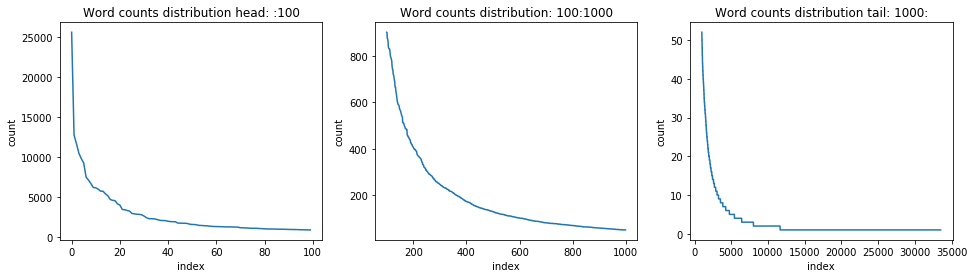

In [12]:
plt.rcParams['figure.figsize'] = (16, 4)

fig, ax = plt.subplots(nrows = 1, ncols = 3)
ax = ax.flatten()
freq = [ w[1] for w in sorted(counts.items(), key = lambda x:x[1], reverse = True) ]

ax[0].plot(range(100), freq[:100])
ax[0].set_title('Word counts distribution head: :100')
ax[0].set_ylabel('count')
ax[0].set_xlabel('index')

ax[1].plot(range(100, 1000), freq[100:1000])
ax[1].set_title('Word counts distribution: 100:1000')
ax[1].set_ylabel('count')
ax[1].set_xlabel('index')

ax[2].plot(range(1000, len(freq)), freq[1000:])
ax[2].set_title('Word counts distribution tail: 1000:')
ax[2].set_ylabel('count')
ax[2].set_xlabel('index')

plt.show()

In [13]:
CUTOFF_TAIL_COUNT = 2 * len(labels) if STRUCTURE_OVER_CONTENT else len(labels)
CUTOFF_HEAD_INDEX = 0 if STRUCTURE_OVER_CONTENT else 20

For lexical semantics (`content`) we put more weight on `meaningful` words and less on sequence structure: bigger vocabulary and shorter embeddings. For non-lexical (`structure`) semantics we do not remove most common (usually structural) words, but do remove more from the tail part of vocabulary.

In [14]:
# remove tail (unique, made-up, misspelled, wrong lang, etc.)
vocabulary = [ w for w,c in sorted(counts.items(), key = lambda x:x[1], reverse = True)
                  if c >= CUTOFF_TAIL_COUNT ][CUTOFF_HEAD_INDEX:]
len(vocabulary)

2587

In [15]:
# make sure we have some either CONTENT or STRUCTURE left
data['stats'] = data['words'].apply(lambda x: len([w for w in x if w in vocabulary]))
data = data[data['stats'] > 0]

In [16]:
total = data.groupby('label').size().sort_values(ascending = False).tolist()
total

[25837, 7358, 6276, 5675, 4026, 3510, 3360]

In [17]:
# resample with replacement for balanced representation
balanced = data[data['label'] == labels[0]][['words','label']]
for i in range(1, len(labels)):
    balanced = balanced.append(
        data[data['label'] == labels[i]]\
                .sample(max(total), replace = True)\
                .loc[:,('words','label')], ignore_index = True)
balanced.shape

(180859, 2)

In [18]:
balanced = balanced.sample(frac = 1) # shuffle
balanced.head()

,words,label
130343,"[i, get, out, your, heart]",🙄
47769,"[im, die]",😭
36094,"[i, hate, drive, with, the, sun, in, my, eye]",😭
107129,"[i, needa, learn, how, to, save]",😩
76188,"[happi, birthday, to, the, wee, brother, have,...",❤


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text

In [20]:
vocabulary[:10]

['i', 'the', 'to', 'you', 'my', 'a', 'and', 'it', 'thi', 'me']

In [21]:
vocabulary[-10:]

['string',
 'trigger',
 'youu',
 'du',
 'retard',
 'centr',
 'lex',
 'frozen',
 'anxieti',
 'pill']

In [22]:
# remove most common
LV = len(vocabulary) - CUTOFF_HEAD_INDEX
index = { vocabulary[i]:i - CUTOFF_HEAD_INDEX for i in range(CUTOFF_HEAD_INDEX, len(vocabulary)) }

For structural semantics we allow `holes` in the sequence: words which did not make into vocabulary will keep the place in embedding but indexed with zero (same as padding places).

In [23]:
if STRUCTURE_OVER_CONTENT:
    X = balanced['words'].apply(lambda x: [index.get(word, -1) + 1 for word in x])
else:
    X = balanced['words'].apply(lambda x: [index[word] + 1 for word in x if word in index])

In [24]:
X[:5]

130343                                 [1, 26, 47, 42, 250]
47769                                            [142, 241]
36094                [1, 144, 378, 27, 2, 1173, 14, 5, 395]
107129                           [1, 1732, 562, 52, 3, 541]
76188     [75, 127, 3, 2, 1852, 352, 30, 6, 322, 48, 193...
Name: words, dtype: object

In [25]:
# embeddings length
LE = int(X.apply(lambda x: len(x)).max())
LE

36

In [26]:
X.shape

(180859,)

In [27]:
X = sequence.pad_sequences(X, maxlen = LE)
X[:5]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    1,   26,
          47,   42,  250],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  142,  241],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,  144,  378,   27,    2, 1173,
          14,    5,  395],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    1, 1732,  562,
          52,    3,  541],
    

In [28]:
Y = np.zeros((len(X), len(labels)))
for e in labels:
    Y[:,labels.index(e)] = (balanced['label'] == e).astype('int32')
Y[:5]

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.]])

### Model

In [29]:
LY = len(labels)

# parameters
dropout = 0.1
epochs = 100
batch_size = 1024

In [30]:
model = Sequential()
model.add(Embedding(LV + 1, LY, input_length = LE))
#model.add(LSTM(LY, return_sequences = True, input_shape = (LE, LV + 1), dropout = dropout))
model.add(LSTM(LY, dropout = dropout, recurrent_dropout = dropout))
model.add(Dense(LY, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
history = model.fit(X, Y, epochs = epochs, batch_size = batch_size, validation_split = 0.1, verbose = 0)

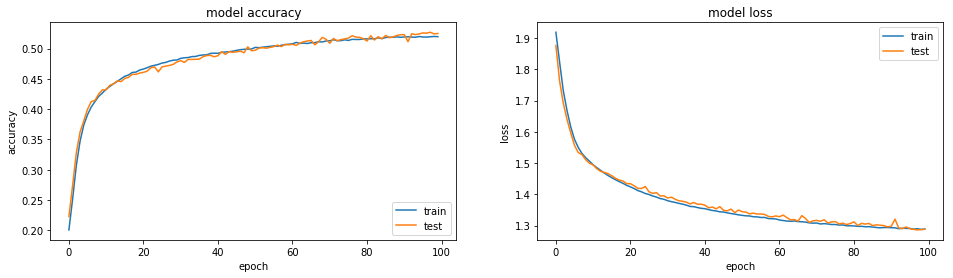

In [31]:
plt.rcParams['figure.figsize'] = (16, 4)

fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax = ax.flatten()

ax[0].plot(history.history['acc'], label = 'train')
ax[0].plot(history.history['val_acc'], label = 'test')
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(loc = 'lower right')

ax[1].plot(history.history['loss'], label = 'train')
ax[1].plot(history.history['val_loss'], label = 'test')
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc = 'upper right')

plt.show()

In [32]:
print('Final epoch accuracy: {:.4f} (train) {:.4f} (validation)'\
    .format(history.history['acc'][-1], history.history['val_acc'][-1]))

Final epoch accuracy: 0.5197 (train) 0.5250 (validation)


### Test

In [33]:
test = pd.read_csv('data/test.csv')

test = test[(test['emo'].isin(labels))]
test['words'] = test['text'].apply(lambda x: [stem(word) for word in x.split()])
test.shape

(3803, 3)

In [34]:
if STRUCTURE_OVER_CONTENT:
    X = test['words'].apply(lambda x: [index.get(word, -1) + 1 for word in x])
else:
    X = test['words'].apply(lambda x: [index[word] + 1 for word in x if word in index])

X = sequence.pad_sequences(X, maxlen = LE)

In [35]:
Y = np.zeros((len(X), len(labels)))
for e in labels:
    Y[:,labels.index(e)] = (test['emo'] == e).astype('int32')

In [36]:
prediction = model.predict_classes(X)

In [37]:
# prediction accuracy
acc = (Y.argmax(1) == prediction).astype('int32').sum()/len(Y)
print('Test accuracy: {:.4f}'.format(acc))

Test accuracy: 0.3247


In [38]:
test['prediction'] = prediction
test['prediction'] = test['prediction'].apply(lambda x: labels[x])

In [39]:
test[Y.argmax(1) != prediction][['text','emo','prediction']]

,text,emo,prediction
1,fans couth my god my god,😍,❤
4,i love him lord,❤,😍
24,if sex is of the relationship that explains wh...,😭,🙄
33,second eye exam until i find out if i ll be ok...,😍,🙄
42,i missed the crawford s at aulani by a few days,😭,❤
44,some of all some fucking hoes fw other girls m...,😂,😩
46,jordan took me to get my first one yesterday,😍,😩
65,some of all some fucking hoes fw other girls m...,😂,😩
69,please tell me why i spent hundreds on my bell...,😂,😩
72,mentoring is a beautiful thing contact mdcpsco...,❤,🤔


After grid search for best parameters for this dataset: non-lexical model slightly but consistently outperforms the lexical.